In [3]:
# General

import numpy as np
import pandas as pd
import re
import os
import pickle
import random
from collections import Counter

# EDA

import matplotlib.pyplot as plt
import plotly.express as px

# NLP

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE

# ML

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [5]:
store = pd.HDFStore('store.h5', 'r')
data = store['data_stemmed']
data

,class,message,no_of_chars,no_of_words,no_of_sentences,no_of_digits,no_of_nonwords,spam,corpus
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0,28,0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,11,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,25,33,1,free entri wkli comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,16,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,14,0,nah think goe usf live around though
...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,21,38,1,nd time tri contact u u å pound prize claim ea...
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,0,8,0,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,0,16,0,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,0,26,0,guy bitch act like interest buy someth els nex...


In [6]:
store.close()

## Creating new features (length, digits, nonwords)

In [7]:
x_train_len, x_test_len = train_test_split(data['no_of_chars'], test_size = 0.25, random_state=0)
x_train_digits, x_test_digits = train_test_split(data['no_of_digits'], test_size = 0.25, random_state=0)
x_train_nonwords, x_test_nonwords = train_test_split(data['no_of_nonwords'], test_size = 0.25, random_state=0)

# Train-Test Split

In [8]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(data['corpus'], data['spam'].values,
test_size = 0.25, random_state = 0)

# Data Manipulation using TF-IDF Vectorizer

In [9]:
# strip_accents removes accents and performs other character normalization during the preprocessing step. 
tfidf = TfidfVectorizer(strip_accents='ascii', max_features=3000)

x_train = tfidf.fit_transform(x_train_raw).toarray()
x_test = tfidf.transform(x_test_raw).toarray()

# Upsampling using SMOTE

In [10]:
smote = SMOTE(random_state=0)

counter = len(y_train)
print('Before upsample (train)', dict(Counter(y_train)))

x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

counter = len(y_train_sm)
print('After upsample (train)', dict(Counter(y_train_sm)))

Before upsample (train) {0: 3629, 1: 550}
After upsample (train) {0: 3629, 1: 3629}


# Visualization of TF-IDF Matrices

In [11]:
svd = TruncatedSVD(random_state=0)
embedding = svd.fit_transform(x_train)

In [12]:
df_tfidf = pd.DataFrame(data=embedding, columns=['Dimension 1', 'Dimension 2'])
df_tfidf['Class'] = y_train
df_tfidf['Class'] = df_tfidf['Class'].map({1:'Spam', 0:'Ham'})
df_tfidf.head()

,Dimension 1,Dimension 2,Class
0,0.048072,-0.001930,Ham
1,0.059603,0.016693,Ham
2,0.055849,-0.024642,Spam
3,0.122672,-0.031425,Spam
4,0.127102,0.003658,Spam


In [13]:
fig = px.scatter(
    df_tfidf,
    x='Dimension 1',
    y='Dimension 2',
    color='Class',
    title="Train set",
    width = 600, 
    color_discrete_sequence = ["teal", "gray"],
    template = 'plotly_white',)
fig.show()

In [14]:
embedding_test = svd.transform(x_test)

df_tfidf = pd.DataFrame(data=embedding_test, columns=['Dimension 1', 'Dimension 2'])
df_tfidf['Class'] = y_test
df_tfidf['Class'] = df_tfidf['Class'].map({1:'Spam', 0:'Ham'})
df_tfidf.head()

fig = px.scatter(
    df_tfidf,
    x='Dimension 1',
    y='Dimension 2',
    color='Class',
    title="Test set",
    width = 600, 
    color_discrete_sequence = ["teal", "gray"],
    template = 'plotly_white',)
fig.show()

In [15]:
embedding_up = svd.transform(x_train_sm)

df_tfidf = pd.DataFrame(data=embedding_up, columns=['Dimension 1', 'Dimension 2'])
df_tfidf['Class'] = y_train_sm
df_tfidf['Class'] = df_tfidf['Class'].map({1:'Spam', 0:'Ham'})
df_tfidf.head()

fig = px.scatter(
    df_tfidf,
    x='Dimension 1',
    y='Dimension 2',
    color='Class',
    title="Train set (upsampled)",
    width = 600, 
    color_discrete_sequence = ["teal", "gray"],
    template = 'plotly_white',)
fig.show()

# Evaluation Metrics

In [11]:
df_eval = pd.DataFrame(columns=['classifier','train_specificity','train_accuracy','train_precision',
'train_f1','train_auc', 'test_specificity', 'test_accuracy', 'test_precision','test_f1','test_auc'])

In [7]:
def eval_metrics(classifier, y_train, yp_train, y_test, yp_test):
    
    print(f"\n-----------------------------{classifier}-----------------------------\n")
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train, digits=4))
    print("--------------------------------------------------------------------------")
    print("Specificity on Train Data:".ljust(30), s1)
    print("Accuracy on Train Data:".ljust(30), round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data:".ljust(30), round(precision_score(y_train, yp_train),4))   
    print("F1 Score on Train Data:".ljust(30), round(f1_score(y_train, yp_train),4))
    print("AUC Score on Train Data:".ljust(30), round(roc_auc_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
          
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    s2 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test, digits=4))   
    print("--------------------------------------------------------------------------")
    print("Specificity on Test Data:".ljust(30), s2)
    print("Accuracy on Test Data:".ljust(30), round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data:".ljust(30), round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data:".ljust(30), round(f1_score(y_test, yp_test), 4))
    print("AUC Score on Test Data:".ljust(30), round(roc_auc_score(y_test, yp_test),4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()

    global df_eval
    df_eval.loc[df_eval.shape[0]] = [classifier,s1, accuracy_score(y_train, yp_train),
    precision_score(y_train, yp_train),f1_score(y_train, yp_train),roc_auc_score(y_train, yp_train),
    s2, accuracy_score(y_test, yp_test),precision_score(y_test, yp_test),f1_score(y_test, yp_test),
    roc_auc_score(y_test, yp_test)]

# Multinomial Naive Bayes

## Naive Bayes Without Upsampling


-----------------------------Naive Bayes Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9816    0.9997    0.9906      3629
           1     0.9979    0.8764    0.9332       550

    accuracy                         0.9835      4179
   macro avg     0.9898    0.9380    0.9619      4179
weighted avg     0.9838    0.9835    0.9830      4179

--------------------------------------------------------------------------
Specificity on Train Data:     0.9997
Accuracy on Train Data:        0.9835
Precision on Train Data:       0.9979
F1 Score on Train Data:        0.9332
AUC Score on Train Data:       0.938
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9676    0.9983    0.9827      1196
           1     0.9874    0.7970    0.8820       197

    accurac

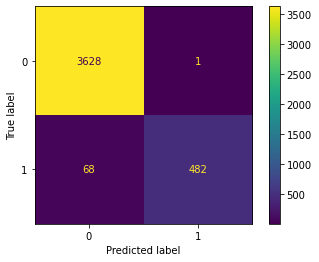

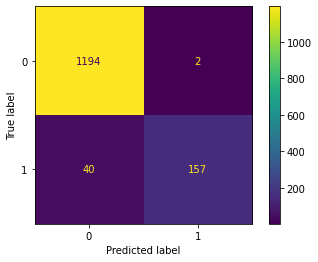

In [ ]:
nb = MultinomialNB()
nb_vanilla = nb.fit(x_train, y_train)

yp_train = nb.predict(x_train)
yp_test = nb.predict(x_test)

eval_metrics("Naive Bayes Classifier", y_train, yp_train, y_test, yp_test)

## Naive Bayes With Upsampling


-----------------------------Naive Bayes Classifier (upsampling)-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9905    0.9785    0.9845      3629
           1     0.9788    0.9906    0.9847      3629

    accuracy                         0.9846      7258
   macro avg     0.9846    0.9846    0.9846      7258
weighted avg     0.9846    0.9846    0.9846      7258

--------------------------------------------------------------------------
Specificity on Train Data:     0.9785
Accuracy on Train Data:        0.9846
Precision on Train Data:       0.9788
F1 Score on Train Data:        0.9847
AUC Score on Train Data:       0.9846
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9915    0.9783    0.9848      1196
           1     0.8779    0.9492    0.9122       19

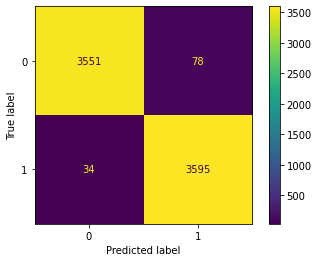

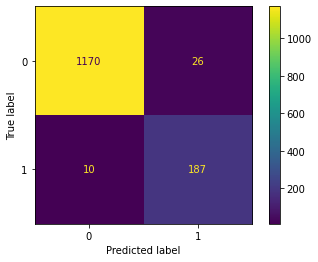

In [ ]:
nb = MultinomialNB()
nb.fit(x_train_sm, y_train_sm)

yp_train = nb.predict(x_train_sm)
yp_test = nb.predict(x_test)

eval_metrics("Naive Bayes Classifier (upsampling)", y_train_sm, yp_train, y_test, yp_test)

## Naive Bayes with Additional Features, No Upsampling


-----------------------------Naive Bayes Classifier (additional features)-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9806    0.9895    0.9851      3629
           1     0.9265    0.8709    0.8978       550

    accuracy                         0.9739      4179
   macro avg     0.9536    0.9302    0.9414      4179
weighted avg     0.9735    0.9739    0.9736      4179

--------------------------------------------------------------------------
Specificity on Train Data:     0.9895
Accuracy on Train Data:        0.9739
Precision on Train Data:       0.9265
F1 Score on Train Data:        0.8978
AUC Score on Train Data:       0.9302
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9776    0.9858    0.9817      1196
           1     0.9091    0.8629    0.8854

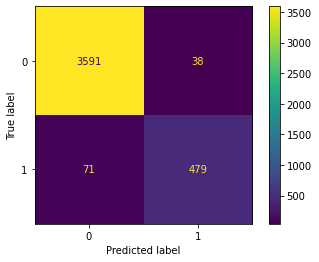

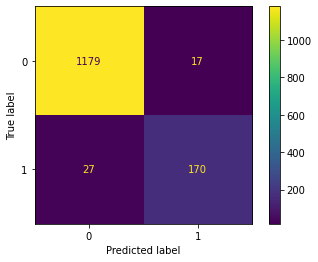

In [ ]:
x_train_f = add_feature(x_train, [x_train_len, x_train_digits, x_train_nonwords])
x_test_f = add_feature(x_test, [x_test_len, x_test_digits, x_test_nonwords])

nb = MultinomialNB()
nb.fit(x_train_f, y_train)

yp_train = nb.predict(x_train_f)
yp_test = nb.predict(x_test_f)

eval_metrics("Naive Bayes Classifier (additional features)", y_train, yp_train, y_test, yp_test)

## Naive Bayes with Upsampling & Additional Features


-----------------------------Naive Bayes Classifier (upsampling + additional features)-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9905    0.9785    0.9845      3629
           1     0.9788    0.9906    0.9847      3629

    accuracy                         0.9846      7258
   macro avg     0.9846    0.9846    0.9846      7258
weighted avg     0.9846    0.9846    0.9846      7258

--------------------------------------------------------------------------
Specificity on Train Data:     0.9785
Accuracy on Train Data:        0.9846
Precision on Train Data:       0.9788
F1 Score on Train Data:        0.9847
AUC Score on Train Data:       0.9846
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9915    0.9783    0.9848      1196
           1     0.8779    0.9

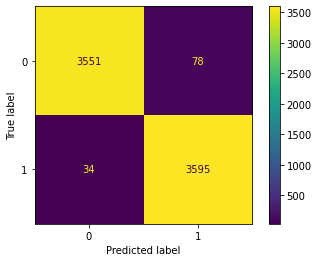

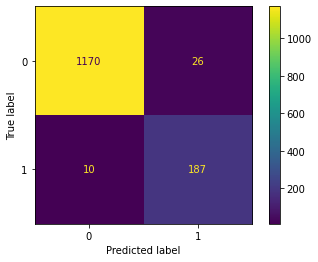

In [ ]:
smote = SMOTE(random_state=0)

x_train_sm_f, y_train_sm_f = smote.fit_resample(x_train, y_train)

nb = MultinomialNB()
nb.fit(x_train_sm_f, y_train_sm_f)

yp_train = nb.predict(x_train_sm_f)
yp_test = nb.predict(x_test)

eval_metrics("Naive Bayes Classifier (upsampling + additional features)", y_train_sm, yp_train, y_test, yp_test)

## Naive Bayes with GridSearch


-----------------------------Naive Bayes with GridSearch-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9816    0.9997    0.9906      3629
           1     0.9979    0.8764    0.9332       550

    accuracy                         0.9835      4179
   macro avg     0.9898    0.9380    0.9619      4179
weighted avg     0.9838    0.9835    0.9830      4179

--------------------------------------------------------------------------
Specificity on Train Data:     0.9997
Accuracy on Train Data:        0.9835
Precision on Train Data:       0.9979
F1 Score on Train Data:        0.9332
AUC Score on Train Data:       0.938
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9676    0.9983    0.9827      1196
           1     0.9874    0.7970    0.8820       197

    ac

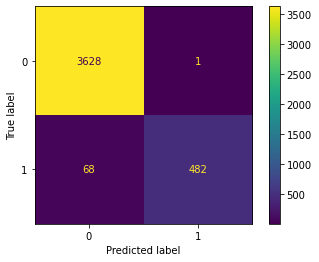

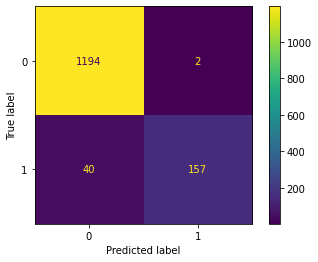

In [ ]:
param_grid = {
    'alpha': [1, 1e-1, 1e-2]
}
nb_GS = GridSearchCV(nb_vanilla, param_grid, scoring='precision')
nb_GS.fit(x_train, y_train)

yp_train = nb_GS.predict(x_train)
yp_test = nb_GS.predict(x_test)

eval_metrics("Naive Bayes with GridSearch", y_train, yp_train, y_test, yp_test)

print(nb_GS.best_params_)

## Naive Bayes with Upsampling &amp; GridSearch


-----------------------------Naive Bayes with GridSearch-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9113    0.9997    0.9535      3629
           1     0.9997    0.9027    0.9487      3629

    accuracy                         0.9512      7258
   macro avg     0.9555    0.9512    0.9511      7258
weighted avg     0.9555    0.9512    0.9511      7258

--------------------------------------------------------------------------
Specificity on Train Data:     0.9997
Accuracy on Train Data:        0.9512
Precision on Train Data:       0.9997
F1 Score on Train Data:        0.9487
AUC Score on Train Data:       0.9512
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9676    0.9983    0.9827      1196
           1     0.9874    0.7970    0.8820       197

    a

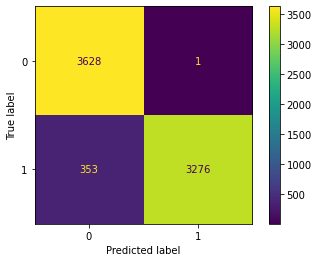

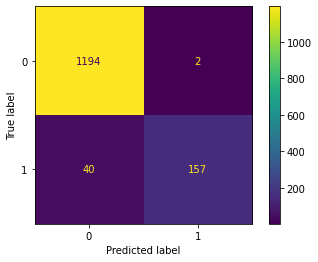

In [ ]:
param_grid = {
    'alpha': [1, 1e-1, 1e-2]
}
nb_sm_GS = GridSearchCV(nb_vanilla, param_grid, scoring='precision')
nb_sm_GS.fit(x_train_sm, y_train_sm)

yp_train = nb_GS.predict(x_train_sm)
yp_test = nb_GS.predict(x_test)

eval_metrics("Naive Bayes with Upsampling & GridSearch", y_train_sm, yp_train, y_test, yp_test)

print(nb_GS.best_params_)

In [ ]:
pickle.dump(nb, open('nb_model.pkl', 'wb')) # wb: open for writing and open and binary mode
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

# Random Forest


-----------------------------Random Forest-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3629
           1     1.0000    1.0000    1.0000       550

    accuracy                         1.0000      4179
   macro avg     1.0000    1.0000    1.0000      4179
weighted avg     1.0000    1.0000    1.0000      4179

--------------------------------------------------------------------------
Specificity on Train Data:     1.0
Accuracy on Train Data:        1.0
Precision on Train Data:       1.0
F1 Score on Train Data:        1.0
AUC Score on Train Data:       1.0
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9739    0.9992    0.9864      1196
           1     0.9940    0.8376    0.9091       197

    accuracy                      

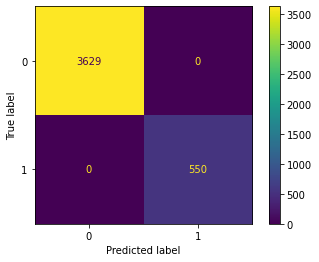

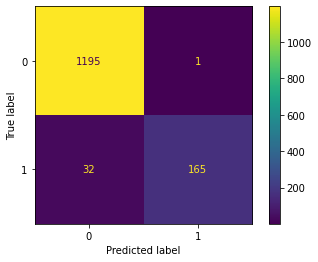

In [ ]:
RFclassifier = RandomForestClassifier(random_state = 30 )
RFclassifier.fit(x_train, y_train)

yp_train = RFclassifier.predict(x_train)
yp_test = RFclassifier.predict(x_test)

eval_metrics("Random Forest", y_train, yp_train, y_test, yp_test)

## Random Forest with RandomizedSearch 

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300)]
random_grid = {'n_estimators': n_estimators,
 'max_depth': [10, 50, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=30)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, scoring = "precision", param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=30, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 134,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [ ]:
rf_random.cv_results_

{'mean_fit_time': array([ 2.94159873, 21.90257208,  0.76331623,  7.81886403, 10.52900139,
        17.64721139,  5.16479953, 10.52180004,  3.05000575,  2.6408937 ]),
 'std_fit_time': array([0.01148346, 0.26523235, 0.02393063, 0.05814697, 0.32879454,
        0.30868623, 0.18568171, 0.07516849, 0.11462537, 0.90765756]),
 'mean_score_time': array([0.10818164, 0.45312818, 0.02826889, 0.18310261, 0.25327086,
        0.38689327, 0.13025983, 0.22866774, 0.0846351 , 0.05924821]),
 'std_score_time': array([0.00374422, 0.03699754, 0.00400483, 0.03040014, 0.0042997 ,
        0.01122868, 0.02333479, 0.01134625, 0.00734454, 0.00843216]),
 'param_n_estimators': masked_array(data=[134, 252, 10, 92, 122, 294, 86, 122, 33, 39],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 2, 5, 10, 2, 10, 2, 10, 10, 10],
              mask=[False, False,

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 5)]
param_grid = {'n_estimators': n_estimators,
 'max_depth': [10, 100, None],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [5, 10]}

# First create the base model to tune
rf = RandomForestClassifier(random_state=30)
# Random search of parameters, using 3 fold cross validation, 
rf_grid = GridSearchCV(estimator = rf, scoring = "precision", param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_grid.fit(x_train, y_train)

print(rf_grid.best_params_)
print(rf_grid.cv_results_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}
{'mean_fit_time': array([ 4.34248177,  4.7627519 ,  5.20994647,  5.87098821,  6.50149655,
        4.28261216,  4.78700256,  5.85644213,  5.8844498 ,  6.38813059,
        4.29840422,  4.59907889,  5.29891666,  5.70033526,  6.45655092,
        4.22188934,  4.76750247,  5.22037832,  5.69741432,  6.32625024,
       17.03425837, 18.84370176, 20.98112313, 23.36624599, 25.44532005,
       16.66277544, 19.92559004, 20.59800871, 29.86425185, 27.07331069,
       14.26985725, 15.99725421, 18.07560468, 19.57932607, 21.15503081,
       14.80062151, 15.96337295, 17.99304167, 19.79498712, 22.83985662,
       22.99386009, 20.39190849, 21.19135094, 26.17215522, 31.12121407,
       17.69128394, 20.50438213, 28.3812422 , 26.58523639, 26.916483  ,
       20.47600659, 19.25180451, 17.74450358, 21.69851184, 29.92586843,
       14.65081533, 16.26463962, 18.954269

In [ ]:
print(rf_grid.best_params_)
print(rf_grid.cv_results_)

{'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 275}
{'mean_fit_time': array([16.75490975, 19.16532453, 22.3783021 , 29.63356511, 28.52352428,
       17.14587871, 22.11172024, 22.59628367, 23.52760959, 24.28711486,
       13.69193967, 15.80938792, 18.23307451, 19.50133832, 23.04824034,
       15.06286764, 17.26647075, 20.52800727, 23.61503696, 25.35217436,
       19.5042239 , 24.31133866, 24.57713715, 23.43293722, 25.47462289,
       16.8949124 , 18.76748164, 21.28789886, 23.74189901, 25.54549313,
       13.69162075, 16.03767602, 17.76634018, 19.92380428, 21.1848371 ,
       14.46008039, 16.05624946, 17.77821183, 19.45202971, 18.8402396 ]), 'std_fit_time': array([0.27631109, 0.62723959, 2.23853468, 2.02650644, 2.39064636,
       0.41147165, 0.84497265, 0.69909706, 1.52173759, 0.44999967,
       0.27017353, 0.21986204, 0.21584629, 0.67814533, 0.24240377,
       0.87914529, 0.39568636, 0.35870603, 0.56098899, 0.52725952,
       1.32568169, 0.60915315, 0.


-----------------------------Random Forest after RandomSearch Tuning-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3629
           1     1.0000    1.0000    1.0000       550

    accuracy                         1.0000      4179
   macro avg     1.0000    1.0000    1.0000      4179
weighted avg     1.0000    1.0000    1.0000      4179

--------------------------------------------------------------------------
Specificity on Train Data:     1.0
Accuracy on Train Data:        1.0
Precision on Train Data:       1.0
F1 Score on Train Data:        1.0
AUC Score on Train Data:       1.0
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9739    0.9992    0.9864      1196
           1     0.9940    0.8376    0.9091       197

    accu

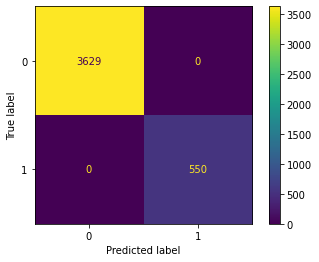

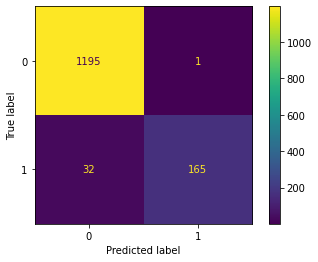

In [12]:
# RFclassifier = RandomForestClassifier(n_estimators = 275, max_depth = 100, min_samples_leaf = 2, min_samples_split = 5, random_state=30)

RFclassifier = RandomForestClassifier(n_estimators = 391, random_state=30)
RFclassifier.fit(x_train, y_train)
yp_train = RFclassifier.predict(x_train)
yp_test = RFclassifier.predict(x_test)

eval_metrics("Random Forest after RandomSearch Tuning", y_train, yp_train, y_test, yp_test)

# Gradient Boosted Decision Trees


-----------------------------Gradient Boosted Decision Trees-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9803    0.9992    0.9896      3629
           1     0.9938    0.8673    0.9262       550

    accuracy                         0.9818      4179
   macro avg     0.9870    0.9332    0.9579      4179
weighted avg     0.9820    0.9818    0.9813      4179

--------------------------------------------------------------------------
Specificity on Train Data:     0.9992
Accuracy on Train Data:        0.9818
Precision on Train Data:       0.9938
F1 Score on Train Data:        0.9262
AUC Score on Train Data:       0.9332
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9636    0.9958    0.9794      1196
           1     0.9682    0.7716    0.8588       197

 

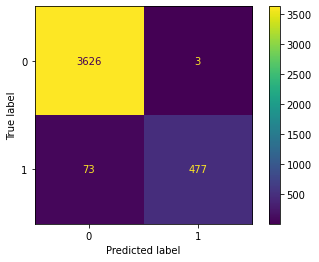

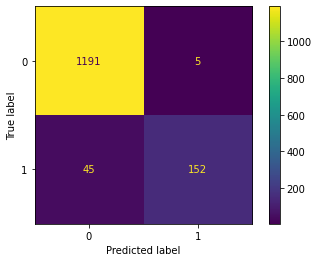

In [ ]:
GBDTclassifier = GradientBoostingClassifier(random_state=30)
GBDTclassifier.fit(x_train, y_train)

yp_train = GBDTclassifier.predict(x_train)
yp_test = GBDTclassifier.predict(x_test)

eval_metrics("Gradient Boosted Decision Trees", y_train, yp_train, y_test, yp_test)

## Gradient Boosted Decision Trees with RandomizedSearch

In [ ]:
# Number of boosting stages
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Loss function
loss_function = ['deviance', 'exponential']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'loss': loss_function}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier(random_state=30)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, scoring = "precision", param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=30, n_jobs = -1)
# Fit the random search model
gb_random.fit(x_train, y_train)

gb_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 10, 'loss': 'exponential'}

## Gradient Boosted Decision Trees with GridSearch

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

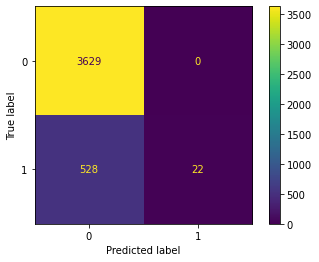

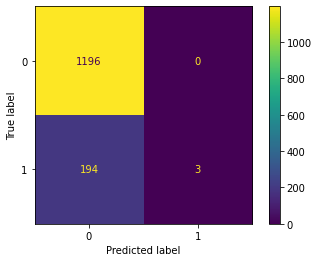

In [ ]:
param_grid = {
    "n_estimators":[10,20],
    "loss":['exponential'],
    "max_depth":[1,3,5],
    "learning_rate":[0.01,0.1,1]
}

gbdt_gs = GridSearchCV(GradientBoostingClassifier(random_state=30), param_grid, scoring ="precision")
gbdt_gs.fit(x_train, y_train)

yp_train = gbdt_gs.predict(x_train)
yp_test = gbdt_gs.predict(x_test)

eval_metrics("Gradient Boosted Decision Trees with GridSearch", y_train, yp_train, y_test, yp_test)

print(gbdt_gs.best_params_)

# Support Vector Machine


-----------------------------SVC-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9964    1.0000    0.9982      3629
           1     1.0000    0.9764    0.9880       550

    accuracy                         0.9969      4179
   macro avg     0.9982    0.9882    0.9931      4179
weighted avg     0.9969    0.9969    0.9969      4179

--------------------------------------------------------------------------
Specificity on Train Data:     1.0
Accuracy on Train Data:        0.9969
Precision on Train Data:       1.0
F1 Score on Train Data:        0.988
AUC Score on Train Data:       0.9882
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9787    0.9975    0.9880      1196
           1     0.9828    0.8680    0.9218       197

    accuracy                        

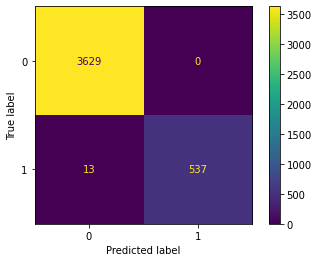

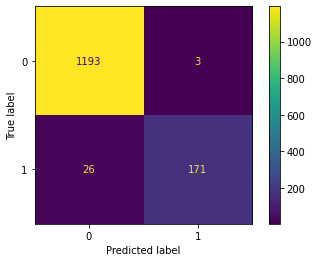

In [ ]:
svc = svm.SVC(random_state=30)
svm_vanilla = svc.fit(x_train, y_train)

yp_train = svc.predict(x_train)
yp_test = svc.predict(x_test)

eval_metrics("SVC", y_train, yp_train, y_test, yp_test)

## SVM with GridSearch


-----------------------------SVC with GridSearch-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0     0.9983    0.9997    0.9990      3629
           1     0.9982    0.9891    0.9936       550

    accuracy                         0.9983      4179
   macro avg     0.9983    0.9944    0.9963      4179
weighted avg     0.9983    0.9983    0.9983      4179

--------------------------------------------------------------------------
Specificity on Train Data:     0.9997
Accuracy on Train Data:        0.9983
Precision on Train Data:       0.9982
F1 Score on Train Data:        0.9936
AUC Score on Train Data:       0.9944
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0     0.9868    0.9967    0.9917      1196
           1     0.9784    0.9188    0.9476       197

    accuracy 

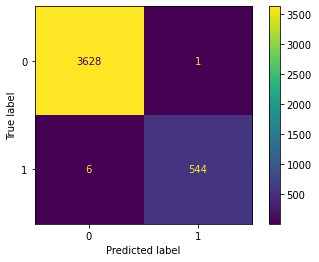

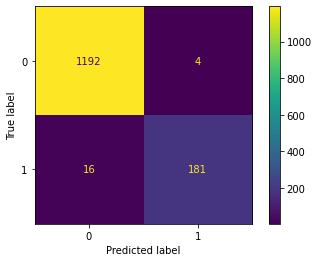

In [ ]:
param_grid = {
    'C': [1, 10, 100], 
    'gamma': [1,0.1,0.01],}

svm_gs = GridSearchCV(svm_vanilla, param_grid)
svm_gs.fit(x_train, y_train)

yp_train = svm_gs.predict(x_train)
yp_test = svm_gs.predict(x_test)

eval_metrics("SVC with GridSearch", y_train, yp_train, y_test, yp_test)

print(svm_gs.best_params_)

# Evaluation

In [ ]:
# df_eval.style.background_gradient(axis=0) 

,classifier,train_specificity,train_accuracy,train_precision,train_f1,train_auc,test_specificity,test_accuracy,test_precision,test_f1,test_auc
0,Naive Bayes Classifier,0.999700,0.983489,0.997930,0.933204,0.938044,0.998300,0.969849,0.987421,0.882022,0.897641
1,Naive Bayes Classifier (upsampling),0.978500,0.984569,0.978764,0.984662,0.984569,0.978300,0.974156,0.877934,0.912195,0.963750
2,Naive Bayes Classifier (additional features),0.989500,0.973917,0.926499,0.897844,0.930219,0.985800,0.968413,0.909091,0.885417,0.924365
3,Naive Bayes Classifier (upsampling + additional features),0.978500,0.984569,0.978764,0.984662,0.984569,0.978300,0.974156,0.877934,0.912195,0.963750
4,Naive Bayes with GridSearch,0.999700,0.983489,0.997930,0.933204,0.938044,0.998300,0.969849,0.987421,0.882022,0.897641
5,Naive Bayes with GridSearch,0.999700,0.951226,0.999695,0.948740,0.951226,0.998300,0.969849,0.987421,0.882022,0.897641
6,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.999200,0.976310,0.993976,0.909091,0.918364
7,Random Forest after RandomSearch Tuning,1.000000,1.000000,1.000000,1.000000,1.000000,0.999200,0.976310,0.993976,0.909091,0.918364
8,Gradient Boosted Decision Trees,0.999200,0.981814,0.993750,0.926214,0.933223,0.995800,0.964106,0.968153,0.858757,0.883697
9,Gradient Boosted Decision Trees with GridSearch,1.000000,0.873654,1.000000,0.076923,0.520000,1.000000,0.860732,1.000000,0.030000,0.507614


In [23]:
store_result = pd.HDFStore('result.h5')
# store_result['result'] = result # save stemmed data
store_result['result'].style.background_gradient(axis=0) 

,classifier,train_specificity,train_accuracy,train_precision,train_f1,train_auc,test_specificity,test_accuracy,test_precision,test_f1,test_auc
0,Naive Bayes Classifier,0.999700,0.983489,0.997930,0.933204,0.938044,0.998300,0.969849,0.987421,0.882022,0.897641
1,Naive Bayes Classifier (upsampling),0.978500,0.984569,0.978764,0.984662,0.984569,0.978300,0.974156,0.877934,0.912195,0.963750
2,Naive Bayes Classifier (additional features),0.989500,0.973917,0.926499,0.897844,0.930219,0.985800,0.968413,0.909091,0.885417,0.924365
3,Naive Bayes Classifier (upsampling + additional features),0.978500,0.984569,0.978764,0.984662,0.984569,0.978300,0.974156,0.877934,0.912195,0.963750
4,Naive Bayes with GridSearch,0.999700,0.983489,0.997930,0.933204,0.938044,0.998300,0.969849,0.987421,0.882022,0.897641
5,Naive Bayes with Upscaling & GridSearch,0.999700,0.951226,0.999695,0.948740,0.951226,0.998300,0.969849,0.987421,0.882022,0.897641
6,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.999200,0.976310,0.993976,0.909091,0.918364
7,Random Forest after RandomSearch Tuning,1.000000,1.000000,1.000000,1.000000,1.000000,0.999200,0.976310,0.993976,0.909091,0.918364
8,Gradient Boosted Decision Trees,0.999200,0.981814,0.993750,0.926214,0.933223,0.995800,0.964106,0.968153,0.858757,0.883697
9,Gradient Boosted Decision Trees with GridSearch,1.000000,0.873654,1.000000,0.076923,0.520000,1.000000,0.860732,1.000000,0.030000,0.507614


In [27]:
store_result['result'].describe().style.background_gradient(axis=0) 

,train_specificity,train_accuracy,train_precision,train_f1,train_auc,test_specificity,test_accuracy,test_precision,test_f1,test_auc
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.995375,0.975995,0.989291,0.888925,0.930207,0.993808,0.964046,0.962039,0.827691,0.888608
std,0.008416,0.034997,0.021276,0.257983,0.132108,0.008136,0.033021,0.045824,0.252307,0.123027
min,0.978500,0.873654,0.926499,0.076923,0.520000,0.978300,0.860732,0.877934,0.030000,0.507614
25%,0.996775,0.979840,0.990003,0.931457,0.936839,0.993300,0.969490,0.953387,0.882022,0.897641
50%,0.999700,0.984029,0.998047,0.966701,0.967897,0.997900,0.972003,0.985090,0.897254,0.918364
75%,1.000000,0.997248,1.000000,0.989432,0.989738,0.998525,0.976310,0.989060,0.912195,0.938997
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985642,1.000000,0.947644,0.963750
